In [1]:
%matplotlib inline 
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy.stats import spearmanr

In [4]:
from access_biology_data import meta, relations, annotation, properties
from access_literature_data import medline
from access_science_shared import standardizer

import sys
sys.path.append('./../src/')
from aging_tools import inout, export, calculators
from access_aging_data import chaperome, earlier_studies, sequencing


In [5]:
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

In [6]:
save_images = False

In [7]:
quanta = 0.05

agg = []
for taxon_id in [9606, 10090]:

    ref_genes = standardizer.reference_genes(taxon_id, 'orp')  # only consider supported protein coding-genes

    pr = properties.genbank_validated_rna(taxon_id)[['gene_ncbi', 'Genbank_validated_RNA: full_SumACGT']].rename(columns={
        'Genbank_validated_RNA: full_SumACGT': 'length'
    })
    pr.loc[:, 'log_length'] = np.log10(pr['length'])
    pr = pr[pr['gene_ncbi'].isin(ref_genes)]
    pr.loc[:, 'rank'] = pr['length'].rank(pct=True)

    painter = []
    hagr = earlier_studies.hagr_mapped_summary(taxon_id)

    mutant = hagr[hagr['influence'].isin(['anti_longevity'])]
    painter_patch = mutant[['gene_ncbi']].reset_index(drop=True)
    painter_patch.loc[:, 'annotation'] = 'anti_longevity'
    painter.append(painter_patch)

    mutant = hagr[hagr['influence'].isin(['pro_longevity'])]
    painter_patch = mutant[['gene_ncbi']].reset_index(drop=True)
    painter_patch.loc[:, 'annotation'] = 'pro_longevity'
    painter.append(painter_patch)

    painter = pd.concat(painter)

    background = pr['gene_ncbi']

    a = calculators.functional_ratio(
            significant_genes= pr[pr['rank']<quanta]['gene_ncbi'],
            background=background,
            painter=painter,
            test='difference')
    a.loc[:, 'taxon_id'] = taxon_id
    a.loc[:, 'genes'] = 'shortest'
    agg.append(a)
    
    a = calculators.functional_ratio(
            significant_genes= pr[pr['rank']>(1-quanta)]['gene_ncbi'],
            background=background,
            painter=painter,
            test='difference')
    
    a.loc[:, 'taxon_id'] = taxon_id
    a.loc[:, 'genes'] = 'longest'
    agg.append(a)

/Users/tstoeger/anaconda3/lib/python3.7/site-packages/fastparquet/dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


In [8]:
h = pd.concat(agg)

In [9]:
h = h.reset_index()

In [10]:
h[h['genes']=='longest']

,annotation,fold_enrichment,pvalue,bonferroni,benjamini_hochberg,in_significant,in_background,taxon_id,genes
2,anti_longevity,-0.652967,0.00355068,0.00710137,0.00427638,16,417,9606,longest
3,pro_longevity,0.634097,0.00427638,0.00855276,0.00427638,25,267,9606,longest
6,anti_longevity,-0.426287,0.0392933,0.0785865,0.0410603,18,307,10090,longest
7,pro_longevity,0.481458,0.0410603,0.0821207,0.0410603,22,200,10090,longest


In [11]:
h[h['genes']=='longest']

,annotation,fold_enrichment,pvalue,bonferroni,benjamini_hochberg,in_significant,in_background,taxon_id,genes
2,anti_longevity,-0.652967,0.00355068,0.00710137,0.00427638,16,417,9606,longest
3,pro_longevity,0.634097,0.00427638,0.00855276,0.00427638,25,267,9606,longest
6,anti_longevity,-0.426287,0.0392933,0.0785865,0.0410603,18,307,10090,longest
7,pro_longevity,0.481458,0.0410603,0.0821207,0.0410603,22,200,10090,longest


In [12]:
h[h['genes']=='shortest']['fold_enrichment']

0    -1.93576
1    0.508497
4    0.477686
5      -1.152
Name: fold_enrichment, dtype: object

In [13]:
h.loc[:, 'joined_label'] = h.loc[:, 'genes'] + '_' + h.loc[:, 'annotation']

In [14]:
h = h.sort_values(['genes', 'annotation'])

In [15]:
if save_images:
    export.export_full_frame(
        '190404_hagr_ratio_for_short_and_long_genes/stats.csv',
        h,
        save_index=False
    )

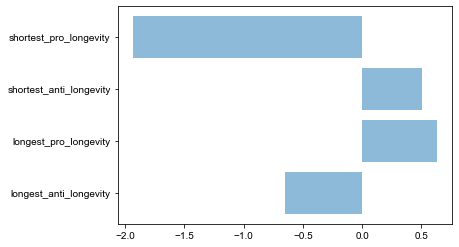

In [16]:
f = h['taxon_id']==9606
v = h[f]['fold_enrichment']
l = h[f]['joined_label']
plt.barh(l, v, align='center', alpha=0.5)

if save_images:
    export.export_image(
        '190404_hagr_ratio_for_short_and_long_genes/human.pdf'
    )

In [17]:
h[f]

,annotation,fold_enrichment,pvalue,bonferroni,benjamini_hochberg,in_significant,in_background,taxon_id,genes,joined_label
2,anti_longevity,-0.652967,0.00355068,0.00710137,0.00427638,16,417,9606,longest,longest_anti_longevity
3,pro_longevity,0.634097,0.00427638,0.00855276,0.00427638,25,267,9606,longest,longest_pro_longevity
1,anti_longevity,0.508497,0.000228273,0.000456547,0.000228273,34,417,9606,shortest,shortest_anti_longevity
0,pro_longevity,-1.93576,5.57337e-05,0.000111467,0.000111467,4,267,9606,shortest,shortest_pro_longevity


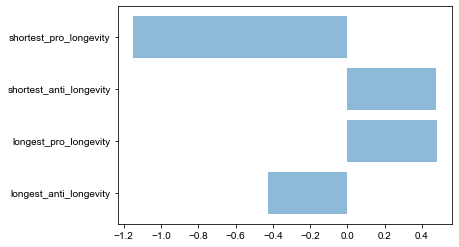

In [18]:
f = h['taxon_id']==10090
v = h[f]['fold_enrichment']
l = h[f]['joined_label']
plt.barh(l, v, align='center', alpha=0.5)

if save_images:
    export.export_image(
        '190404_hagr_ratio_for_short_and_long_genes/mouse.pdf'
    )

In [19]:
h[f]

,annotation,fold_enrichment,pvalue,bonferroni,benjamini_hochberg,in_significant,in_background,taxon_id,genes,joined_label
6,anti_longevity,-0.426287,0.0392933,0.0785865,0.0410603,18,307,10090,longest,longest_anti_longevity
7,pro_longevity,0.481458,0.0410603,0.0821207,0.0410603,22,200,10090,longest,longest_pro_longevity
4,anti_longevity,0.477686,0.0223518,0.0447035,0.0431121,19,307,10090,shortest,shortest_anti_longevity
5,pro_longevity,-1.152,0.0431121,0.0862243,0.0431121,4,200,10090,shortest,shortest_pro_longevity


In [22]:
h['expectation'] = h['in_significant'] / (2**h['fold_enrichment'])

In [28]:
h[
    ['taxon_id', 'genes', 'annotation', 'in_significant', 
     'in_background', 'expectation', 'fold_enrichment']].sort_values(
    ['taxon_id', 'genes', 'annotation'], ascending=[1, 0, 0]

)

,taxon_id,genes,annotation,in_significant,in_background,expectation,fold_enrichment
0,9606,shortest,pro_longevity,4,267,15.3032,-1.93576
1,9606,shortest,anti_longevity,34,417,23.9005,0.508497
3,9606,longest,pro_longevity,25,267,16.1086,0.634097
2,9606,longest,anti_longevity,16,417,25.1584,-0.652967
5,10090,shortest,pro_longevity,4,200,8.88889,-1.152
4,10090,shortest,anti_longevity,19,307,13.6444,0.477686
7,10090,longest,pro_longevity,22,200,15.7576,0.481458
6,10090,longest,anti_longevity,18,307,24.1879,-0.426287
